In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
# Data 
data = pd.read_csv('/Users/mario.iuliano/marios_env/Portfolio/test/feature_selection/churn/telco.csv')

In [3]:
# Drop unnecessary columns
data.drop(columns=['customerID', 'TotalCharges'], inplace=True)

In [4]:
data.columns = data.columns.str.lower().str.replace(' ', '_')

In [7]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

In [41]:
data_encoded = data.copy()
data_encoded.drop(columns=['churn'], inplace=True)
ohe = OneHotEncoder(sparse_output=False)
categorical_cols = data_encoded.select_dtypes(include=['object'])
ohe = OneHotEncoder(sparse_output = False)
preprocessor = ColumnTransformer(
    transformers = [ 
        ('cat', ohe, categorical_cols.columns),
    ], 
) 

In [42]:
from sklearn.feature_selection import SelectKBest, chi2 

X = preprocessor.fit_transform(data_encoded)
y = data['churn']

selector = SelectKBest(score_func = chi2, k = 'all')
Xkbest = selector.fit_transform(X, y)

In [43]:
feature_names = [c.replace('cat__', '').replace(' ', '_') for c in preprocessor.get_feature_names_out()] 
chi2_scores = selector.scores_

In [44]:
chi2_df = pd.DataFrame({
                            'Feature': feature_names,
                            'Chi2': chi2_scores
                        })

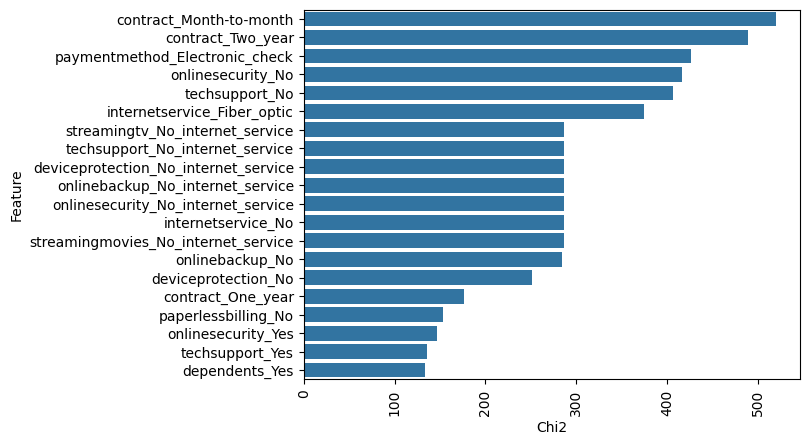

In [61]:
# Plot chi2 scores
chi2_df_sorted =chi2_df.sort_values(by = 'Chi2', ascending = False)

sns.barplot(data = chi2_df_sorted[:20], y = 'Feature', x = 'Chi2')
plt.xticks(rotation = 90)
plt.show()

In [65]:
top_20_features = chi2_df_sorted[:20].Feature.to_list()
drop = [
    'streamingmovies', 
    'deviceprotection', 
]

top_20_features = [f.split('_')[0] for f in top_20_features if f.split('_')[0] not in drop]

In [74]:
# Add numerical features
numerical_features = data.select_dtypes(include=['int64', 'float64']).columns
top_20_features = top_20_features + numerical_features.tolist()
top_20_features = list(set(top_20_features))

In [75]:
top_20_features

['onlinebackup',
 'paymentmethod',
 'contract',
 'streamingtv',
 'techsupport',
 'onlinesecurity',
 'paperlessbilling',
 'seniorcitizen',
 'tenure',
 'dependents',
 'monthlycharges',
 'internetservice']

In [76]:
pca_data = data[top_20_features]

In [77]:
encoded_data = pd.get_dummies(pca_data)

In [78]:
encoded_data

,seniorcitizen,tenure,monthlycharges,onlinebackup_No,onlinebackup_No internet service,onlinebackup_Yes,paymentmethod_Bank transfer (automatic),paymentmethod_Credit card (automatic),paymentmethod_Electronic check,paymentmethod_Mailed check,...,onlinesecurity_No,onlinesecurity_No internet service,onlinesecurity_Yes,paperlessbilling_No,paperlessbilling_Yes,dependents_No,dependents_Yes,internetservice_DSL,internetservice_Fiber optic,internetservice_No
0,0,1,29.85,False,False,True,False,False,True,False,...,True,False,False,False,True,True,False,True,False,False
1,0,34,56.95,True,False,False,False,False,False,True,...,False,False,True,True,False,True,False,True,False,False
2,0,2,53.85,False,False,True,False,False,False,True,...,False,False,True,False,True,True,False,True,False,False
3,0,45,42.30,True,False,False,True,False,False,False,...,False,False,True,True,False,True,False,True,False,False
4,0,2,70.70,True,False,False,False,False,True,False,...,True,False,False,False,True,True,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,0,24,84.80,True,False,False,False,False,False,True,...,False,False,True,False,True,False,True,True,False,False
7039,0,72,103.20,False,False,True,False,True,False,False,...,True,False,False,False,True,False,True,False,True,False
7040,0,11,29.60,True,False,False,False,False,True,False,...,False,False,True,False,True,False,True,True,False,False
7041,1,4,74.40,True,False,False,False,False,False,True,...,True,False,False,False,True,True,False,False,True,False


In [121]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from imblearn.combine import SMOTEENN

X = encoded_data
y = data['churn']

smote = SMOTEENN()
X_resampled, y_resampled = smote.fit_resample(X, y)

In [122]:
scaler = StandardScaler()
pca_data_scaled = scaler.fit_transform(X_resampled)

pca = PCA(n_components=2)
pca_components = pca.fit_transform(pca_data_scaled)

In [123]:
pca_df = pd.DataFrame(
    {
        'PC1': pca_components[:, 0],
        'PC2': pca_components[:, 1],
        'Churn': y_resampled
    }
)

<Axes: xlabel='PC1', ylabel='PC2'>

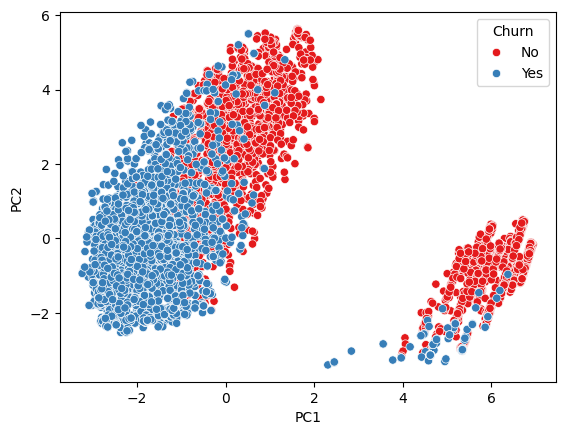

In [124]:
sns.scatterplot(
    data=pca_df,
    x='PC1',
    y='PC2',
    hue='Churn',
    palette='Set1'
)

In [128]:
components = pca.components_[0]
pd.Series(components, index = X_resampled.columns).sort_values(ascending = False).tail()

onlinebackup_No               -0.203134
internetservice_Fiber optic   -0.219314
techsupport_No                -0.243473
onlinesecurity_No             -0.245999
monthlycharges                -0.251026
dtype: float64

In [106]:
data = pd.read_csv('/Users/mario.iuliano/marios_env/Portfolio/test/feature_selection/churn/telco.csv')
data.drop(columns=['customerID', 'TotalCharges'], inplace=True)
data.columns = data.columns.str.lower().str.replace(' ', '_')

<Axes: xlabel='PC1', ylabel='PC2'>

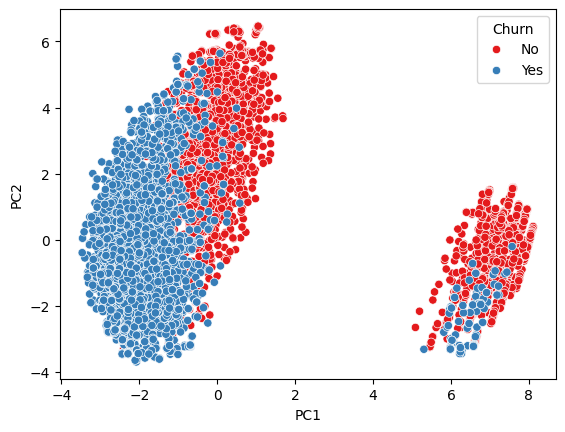

In [116]:
X = data.drop(columns=['churn'])
y = data['churn']
X = pd.get_dummies(X)

sm = SMOTEENN()
X_resampled, y_resampled = sm.fit_resample(X, y)

sc = StandardScaler()
X_resampled = sc.fit_transform(X_resampled)
X_resampled_df = pd.DataFrame(X_resampled, columns=X.columns)
pca_test = PCA(n_components=2)
pca_test_components = pca_test.fit_transform(X_resampled)
pca_test_df = pd.DataFrame(
    {
        'PC1': pca_test_components[:, 0],
        'PC2': pca_test_components[:, 1],
        'Churn': y_resampled
    }
)
sns.scatterplot(
    data=pca_test_df,
    x='PC1',
    y='PC2',
    hue='Churn',
    palette='Set1'
)


In [120]:
pd.Series(pca_test.components_[0], index=X_resampled_df.columns).sort_values(ascending=False).head()

streamingmovies_No internet service     0.27467
deviceprotection_No internet service    0.27467
onlinebackup_No internet service        0.27467
techsupport_No internet service         0.27467
streamingtv_No internet service         0.27467
dtype: float64

In [115]:
pca_test.components_

array([[-0.05386471,  0.07396861, -0.2209893 , -0.02176708, -0.01987532,
        -0.06931694,  0.02687225, -0.10807239,  0.07386334, -0.02946293,
         0.02711689,  0.0723891 , -0.02946293, -0.08438251, -0.042479  ,
        -0.17972444,  0.27638723, -0.2071127 ,  0.27638723, -0.0455908 ,
        -0.17456793,  0.27638723, -0.08245843, -0.16985801,  0.27638723,
        -0.0849854 , -0.20695769,  0.27638723, -0.04446061, -0.12195712,
         0.27638723, -0.11676022, -0.12064083,  0.27638723, -0.11962233,
        -0.15768249,  0.04848629,  0.12702099,  0.11792514, -0.15515189,
         0.0184436 ,  0.01947605, -0.15614084,  0.0930908 ],
       [-0.00073283,  0.33753443,  0.16821043, -0.01998654, -0.00429296,
        -0.23368887,  0.21957103, -0.15189036,  0.14532513,  0.01940724,
        -0.01942617, -0.16402124,  0.01940724,  0.14453907,  0.08154816,
        -0.01529313, -0.07514229, -0.13458176, -0.07514229,  0.2309041 ,
        -0.14187924, -0.07514229,  0.21986255, -0.17092538, -0.